# Monte Carlo Simulation of patient arrival at a hospital

In [ ]:
# Load necessary libraries
#install.packages("ggplot2")
library(ggplot2)

# Set random seed for reproducibility
set.seed(123)

# Simulation parameters
lambda <- 10 / 60  # Arrival rate per minute (10 patients per hour)
mu_critical <- 1 / 30  # Service rate for critical patients (1 patient per 10 mins)
mu_noncritical <- 1 / 10  # Service rate for non-critical patients (1 patient per 5 mins)
simulation_time <- 720  # Simulate for 12 hours (720 minutes)
num_simulations <- 1000  # Number of Monte Carlo runs
num_doctors <- 3  # Number of available doctors

# Priority system with misclassification
critical_probability <- 0.2  # True critical patients (20%)
misclassification_rate <- 0.5  # 50% of non-critical patients are misclassified

# Store results
waiting_times_critical <- numeric(num_simulations)
waiting_times_noncritical <- numeric(num_simulations)

In [12]:
for (i in 1:num_simulations) {
  time <- 0  # Current simulation time
  queue_critical <- c()  # Queue for critical patients
  queue_noncritical <- c()  # Queue for non-critical patients
  doctors_available <- rep(0, num_doctors)  # Track when each doctor is free
  
  while (time < simulation_time) {
    # Generate next patient arrival time
    interarrival_time <- rexp(1, rate = lambda)
    time <- time + interarrival_time
    
    # Determine if patient is truly critical or non-critical
    is_true_critical <- runif(1) < critical_probability  # 20% chance of being truly critical
    
    # Misclassification logic: 50% of non-critical patients are wrongly classified as critical
    if (!is_true_critical && runif(1) < misclassification_rate) {
      is_critical <- TRUE
      misclassified <- TRUE
    } else {
      is_critical <- is_true_critical
      misclassified <- FALSE
    }
    
    # Generate service time
    if (is_critical) {
      if (misclassified) {
        service_time <- rexp(1, rate = 2 * mu_critical)  # Misclassified patients take half the critical service time
      } else {
        service_time <- rexp(1, rate = mu_critical)  # True critical service time
      }
    } else {
      service_time <- rexp(1, rate = mu_noncritical)  # Normal non-critical service time
    }
    
    # Find the first available doctor
    next_available_time <- min(doctors_available)
    doctor_index <- which.min(doctors_available)
    
    # Determine start time based on priority queueing and doctor availability
    if (is_critical) {
      start_time <- max(time, queue_critical[length(queue_critical)], next_available_time, na.rm = TRUE)
      queue_critical <- c(queue_critical, start_time + service_time)
      waiting_times_critical[i] <- waiting_times_critical[i] + (start_time - time)
      
      # If patient was misclassified, they are now correctly reallocated
      if (misclassified) {
        # After half the usual critical service time, they go back to non-critical queue
        start_time <- max(queue_critical[length(queue_critical)], queue_noncritical[length(queue_noncritical)], na.rm = TRUE)
        queue_noncritical <- c(queue_noncritical, start_time + service_time)
        waiting_times_noncritical[i] <- waiting_times_noncritical[i] + (start_time - time)
      }
    } else {
      start_time <- max(time, 
                        ifelse(length(queue_critical) > 0, queue_critical[length(queue_critical)], 0),
                        ifelse(length(queue_noncritical) > 0, queue_noncritical[length(queue_noncritical)], 0),
                        next_available_time, na.rm = TRUE)
      queue_noncritical <- c(queue_noncritical, start_time + service_time)
      waiting_times_noncritical[i] <- waiting_times_noncritical[i] + (start_time - time)
    }
    
    # Assign doctor to this patient
    doctors_available[doctor_index] <- start_time + service_time
  }
}

# Convert waiting times to minutes
waiting_times_critical <- waiting_times_critical / num_simulations
waiting_times_noncritical <- waiting_times_noncritical / num_simulations

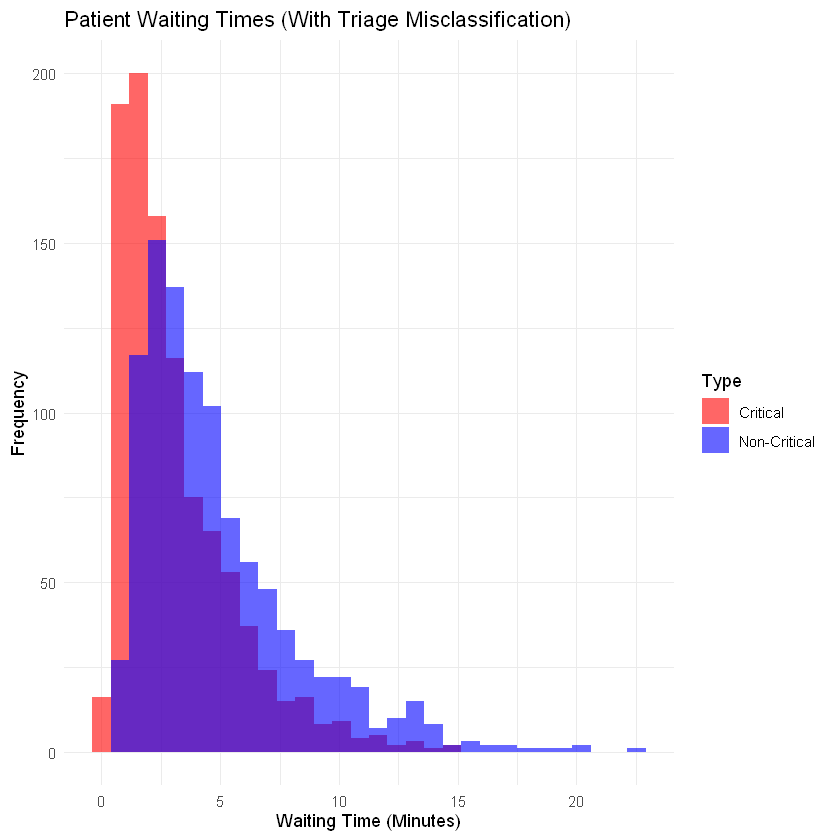

In [14]:
# Create a data frame for visualization
df <- data.frame(
  Type = rep(c("Critical", "Non-Critical"), each = num_simulations),
  Waiting_Time = c(waiting_times_critical, waiting_times_noncritical)
)

# Plot histogram
ggplot(df, aes(x = Waiting_Time, fill = Type)) +
  geom_histogram(bins = 30, alpha = 0.6, position = "identity") +
  labs(title = "Patient Waiting Times (With Triage Misclassification)",
       x = "Waiting Time (Minutes)",
       y = "Frequency") +
  theme_minimal() +
  scale_fill_manual(values = c("red", "blue"))